- Base article https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810

- KL divergence cannot have 0 with p and q. "But many people simply choose to throw out those values (i.e., by erasing 0ln(0) ln(a/0) and writing 0 in its place)." https://mathoverflow.net/a/72672/148436

In [18]:
from dlcliche.notebook import *
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set()

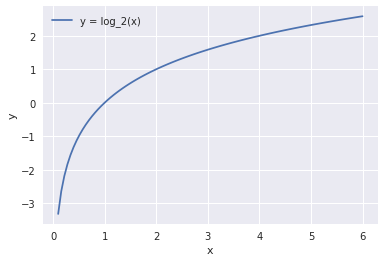

In [24]:
x = np.linspace(0.1, 6, 100)
plt.plot(x, np.log2(x), label='y = log_2(x)')
plt.xlabel('x'); plt.ylabel('y'); plt.legend();

In [20]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

The KL divergence between a normal distribution with a mean of 0 and a standard deviation of 2 and another distribution with a mean of 2 and a standard deviation of 2 is equal to 500.

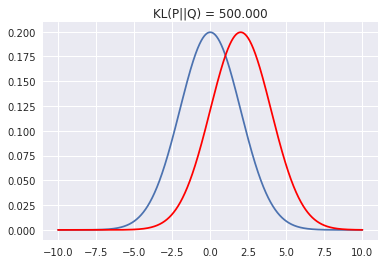

In [71]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red');

If we measure the KL divergence between the initial probability distribution and another distribution with a mean of 5 and a standard deviation of 4, we expect the KL divergence to be higher than in the previous example.

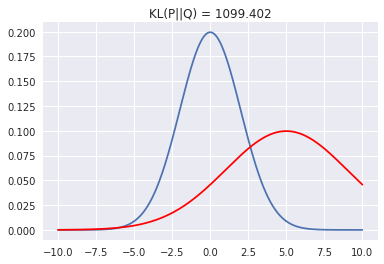

In [28]:
q = norm.pdf(x, 5, 4)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red');

It’s important to note that the KL divergence is not symmetrical. In other words, if we switch P for Q and vice versa, we get a different result.

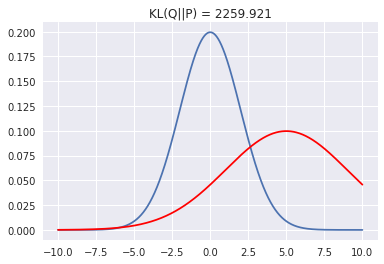

In [30]:
q = norm.pdf(x, 5, 4)
plt.title('KL(Q||P) = %1.3f' % kl_divergence(q, p))
plt.plot(x, p)
plt.plot(x, q, c='red');

The lower the KL divergence, the closer the two distributions are to one another. Therefore, as in the case of t-SNE and Gaussian Mixture Models, we can estimate the Gaussian parameters of one distribution by minimizing its KL divergence with respect to another.

## Minimizing KL Divergence

Let’s see how we could go about minimizing the KL divergence between two probability distributions using gradient descent. To begin, we create a probability distribution with a known mean (0) and variance (2). Then, we create another distribution with random parameters.

In [31]:
x = np.arange(-10, 10, 0.001)
p_pdf = norm.pdf(x, 0, 2).reshape(1, -1)
np.random.seed(0)
random_mean = np.random.randint(10, size=1)
random_sigma = np.random.randint(10, size=1)
random_pdf = norm.pdf(x, random_mean, random_sigma).reshape(1, -1)

Given that we are using gradient descent, we need to select values for the hyperparameters (i.e. step size, number of iterations).

Just like numpy, in tensorflow we need to allocate memory for variables. For the variable q, we use the equation for a normal distribution given mu and sigma, only we exclude the part before the exponent since we’re normalizing the result.

$y = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

### PyTorch implementation, plus animation

In [82]:
def torch_kl_divergence(p, q):
    return torch.sum(torch.where(p != 0, p * torch.log(p / q), torch.tensor([0.], dtype=torch.float32)))

def test_torch_kl_divergence():
    x = np.arange(-10, 10, 0.001)
    p = norm.pdf(x, 0, 2)
    q = norm.pdf(x, 2, 2)

    print(torch_kl_divergence(torch.tensor(p, dtype=torch.float32), torch.tensor(q, dtype=torch.float32)))

<IPython.core.display.Javascript object>


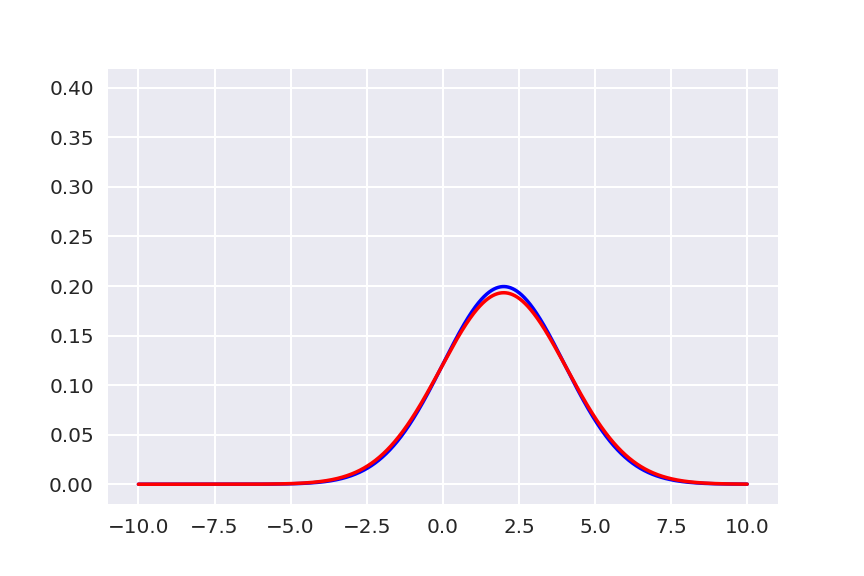

  mu: 1.9996691 -1999.6689453  sigma: 7.9965658 -6996.5654297 -- KL divergence = 2805.4243164 @0
  mu: 1.9996700 -0.0009851  sigma: 7.8793344 117.2315903 -- KL divergence = 917.3639526 @1
  mu: 1.9996710 -0.0009989  sigma: 7.7605963 118.7379379 -- KL divergence = 903.5327759 @2
  mu: 1.9996721 -0.0010138  sigma: 7.6402974 120.2987823 -- KL divergence = 889.3416138 @3
  mu: 1.9996731 -0.0010294  sigma: 7.5183802 121.9171906 -- KL divergence = 874.7730713 @4
  mu: 1.9996742 -0.0010431  sigma: 7.3947840 123.5964203 -- KL divergence = 859.8071899 @5
  mu: 1.9996753 -0.0010583  sigma: 7.2694440 125.3398132 -- KL divergence = 844.4238281 @6
  mu: 1.9996763 -0.0010737  sigma: 7.1422930 127.1511459 -- KL divergence = 828.6007080 @7
  mu: 1.9996774 -0.0010928  sigma: 7.0132589 129.0342407 -- KL divergence = 812.3141479 @8
  mu: 1.9996785 -0.0011116  sigma: 6.8822656 130.9933319 -- KL divergence = 795.5384521 @9
  mu: 1.9996796 -0.0011317  sigma: 6.7492328 133.0327454 -- KL divergence = 778.2462

In [208]:
%matplotlib nbagg
import matplotlib.animation as animation

lrs = [0.001, 0.001]
epochs = 100

def torch_normal(x, mu, sigma):
    t_x = torch.tensor(x, dtype=torch.float32)
    return 1 / (torch.sqrt(2 * np.pi * (sigma**2))) \
        * torch.exp(-((t_x - mu)**2) / (2. * (sigma**2)))

def plot_pdf(y, color):
    return plt.plot(x, y.detach().numpy(), color=color)

x = np.arange(-10, 10, 0.001)
p = torch_normal(x,
                 torch.tensor([2], dtype=torch.float32),
                 torch.tensor([2], dtype=torch.float32))

params = {
    'mu': torch.tensor([0], dtype=torch.float32, requires_grad=True),
    'sigma': torch.tensor([1], dtype=torch.float32, requires_grad=True),
}

fig = plt.figure()
plot_pdf(p, color='blue')
frames = []
for i in range(epochs):
    # Make q for this iteration
    q = torch_normal(x, params['mu'], params['sigma'])
    frames.append(plot_pdf(q, color='red'))
    # Calculate KL divergence, objective function to make it closer to zero
    value = torch_kl_divergence(p, q)
    value.backward()
    # Anatomy of pytorch
    if 1:
        if i == 0:
            print(value.grad_fn)
    # Optimize, naively for this time
    for learning_rate, k in zip(lrs, params):
        param = params[k]
        param.data -= learning_rate * param.grad.data
        print('  %s: %.7f %.7f' % (k, param.data, param.grad.data), end='')
        param.grad.data.zero_()
    print(f' -- KL divergence = {value.data:.7f} @{i}')

ani = animation.ArtistAnimation(fig, frames, interval=50)
plt.show()

## Hand calculation of derivative of KL divergence over normal distributions

Confirming _why 1st iteration makes big gradient?_

- [Link to Wolfram solver](https://www.wolframalpha.com/input/?i=derivative+of+p+log%28p%2F%281%2F%28x√2π%29+e%5E%28-%28x0-y%29%5E2%2F%282x%5E2%29%29%29%29)

$\frac{d}{d\sigma}(p \log(\exp({\frac{(x0 - \mu)^2}{(2 \sigma^2)}}) p \sqrt{2 \pi} \sigma)) = \frac{p (\sigma^2 - (x0 - \mu)^2)}{\sigma^3}$

$\frac{d}{d\mu}(p \log(\exp({\frac{(x0 - \mu)^2}{(2 \sigma^2)}}) p \sqrt{2 \pi} \sigma)) = \frac{-p (x0 - \mu)}{\sigma^2}$

In [213]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 2, 2)
q_mu, q_sigma = np.ones_like(x) * 0, np.ones_like(x) * 1

def d_KL(x, p, q_mu, q_sigma):
    '''KL divergence of single data point'''
    d_mu = (p * (q_sigma**2 - (x - q_mu)**2))/q_sigma**3
    d_sigma = -((p * (x - q_mu))/q_sigma**2)
    return d_mu.sum(), d_sigma.sum()

d_KL(x, p, q_mu, q_sigma)

(-6996.562958632024, -1999.6686725477991)

## Test - solving quadratic function by pytorch

In [167]:
guess = torch.tensor([1], dtype=torch.float64, requires_grad=True) 

def loss_fn(x): return x**2 - 4*x + 1

params = [guess]
learning_rate = 0.1
for _ in range(50):
    value = loss_fn(guess)
    value.backward()
    for param in params:
        param.data -= learning_rate * param.grad.data
        print('%.7f %.7f %.7f' % (param.data, value.data, param.grad.data))
        param.grad.data.zero_()

1.2000000 -2.0000000 -2.0000000
1.3600000 -2.3600000 -1.6000000
1.4880000 -2.5904000 -1.2800000
1.5904000 -2.7378560 -1.0240000
1.6723200 -2.8322278 -0.8192000
1.7378560 -2.8926258 -0.6553600
1.7902848 -2.9312805 -0.5242880
1.8322278 -2.9560195 -0.4194304
1.8657823 -2.9718525 -0.3355443
1.8926258 -2.9819856 -0.2684355
1.9141007 -2.9884708 -0.2147484
1.9312805 -2.9926213 -0.1717987
1.9450244 -2.9952776 -0.1374390
1.9560195 -2.9969777 -0.1099512
1.9648156 -2.9980657 -0.0879609
1.9718525 -2.9987621 -0.0703687
1.9774820 -2.9992077 -0.0562950
1.9819856 -2.9994929 -0.0450360
1.9855885 -2.9996755 -0.0360288
1.9884708 -2.9997923 -0.0288230
1.9907766 -2.9998671 -0.0230584
1.9926213 -2.9999149 -0.0184467
1.9940970 -2.9999456 -0.0147574
1.9952776 -2.9999652 -0.0118059
1.9962221 -2.9999777 -0.0094447
1.9969777 -2.9999857 -0.0075558
1.9975821 -2.9999909 -0.0060446
1.9980657 -2.9999942 -0.0048357
1.9984526 -2.9999963 -0.0038686
1.9987621 -2.9999976 -0.0030949
1.9990096 -2.9999985 -0.0024759
1.999207